# Simulation of one voxel encoding for different probabilities



In [1]:
# Import useful modules
import os
import scipy
import random as rand
from scipy import io as sio
from scipy import stats
from scipy.stats.stats import pearsonr
import numpy as np
#import decimal
# import matplotlib
# matplotlib.use('Agg')    # To avoid bugs
import matplotlib.pyplot as plt
import matplotlib
width = 18
height = 16
#matplotlib.rcParams['figure.figsize'] = [width, height]
import pandas as pd


import pickle
import itertools
import time

import copy

import multiprocessing as mp

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import neural_proba
from neural_proba import distrib
from neural_proba import tuning_curve
from neural_proba import voxel
from neural_proba import experiment
from neural_proba import fmri

import utils


## Properties of the models

Here are the properties related to :
- the tuning curves (types, number, variance, ...) both true and fitted. 
- the neural mixture (sparsities)
- the subjects
- the sessions
- the SNR
- the type of linear regression performed

In [2]:
# All parameters are here

# Define the seed to reproduce results from random processes
rand.seed(5);

# INPUTS

# The parameters related to the scheme
scheme_array = ['gaussian_ppc', 'sigmoid_ppc', 'gaussian_dpc', 'sigmoid_dpc']
n_schemes = len(scheme_array)

# The parameters related to the tuning curves to be explored
N_array = np.array([2, 4, 6, 8, 10, 14, 20])

t_mu_gaussian_array = np.array([0.15, 0.1, 7e-2, 5e-2, 4e-2, 3e-2, 2e-2])
t_conf_gaussian_array = np.array([0.25, 0.15, 0.10, 8e-2, 6e-2, 4e-2, 3e-2])

t_mu_sigmoid_array = np.sqrt(2*np.pi)/4*t_mu_gaussian_array
t_conf_sigmoid_array = np.sqrt(2*np.pi)/4*t_conf_gaussian_array

# Lower and upper bounds of the encoded summary quantity (for tuning curves)
tc_lower_bound_mu = 0
tc_upper_bound_mu = 1
tc_lower_bound_conf = 1.1
# we define the upper bound to be a bit away from the highest uncertainty
tc_upper_bound_conf = 2.6

# The number of N to be tested
n_N = len(N_array)

# The number of fractions tested (related to W)
n_fractions = 1335

# Sparsity exponents
sparsity_exp_array = np.array([1, 2, 4, 8])
n_sparsity_exp = len(sparsity_exp_array)

# The number of subjects
n_subjects = 20

# The number of sessions
n_sessions = 4

# The number of stimuli per session
n_stimuli = 380

# Way to compute the distributions from the sequence
distrib_type = 'HMM'

# Load the corresponding data
[p1g2_dist_array, p1g2_mu_array, p1g2_sd_array] = neural_proba.import_distrib_param(n_subjects, n_sessions, n_stimuli,
                                                                                      distrib_type)
# SNR as defined by ||signal||²/(||signal||²+||noise||²)
snr = 0.1

# Type of regression
regr = linear_model.LinearRegression(n_jobs=-1)

## Handle the data

### Row data loading and visualization


In [3]:
# Load the design matrices and specify their size
with open("output/design_matrices/X_20sub_f.txt", "rb") as fp: #X_20sub_f.txt", "rb") as fp:   # Unpickling
    X = pickle.load(fp)

# # Just for now
# n_subjects = 1
# n_sessions = 4
# n_N = 2
# n_schemes = 4

X of size : (362, 12)
Scheme : gaussian_ppc
N=6
Subject n°0
Session n°3

Tuning curve n°1 related to mu
X of size : (362, 12)
Scheme : gaussian_ppc
N=6
Subject n°0
Session n°3

Tuning curve n°0 related to the confidence


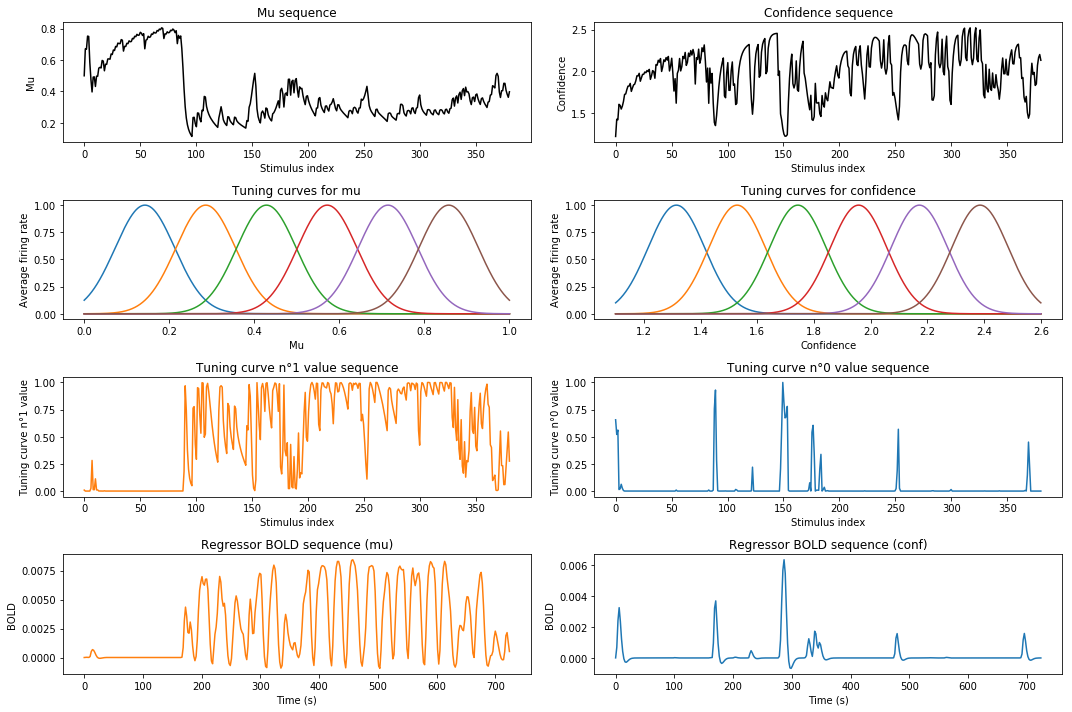

In [4]:
# Plot signal compared to summary statistics for the desired model
######################################################################################
k_scheme = 0
k_N = 2
k_subject = 0
k_session = 3
n_stimuli = 380
#######################################################################################
# Tuning curve indices to visualize
i_mu = 1
i_conf = 0

# Test everything is fine
mu = p1g2_mu_array[k_subject][k_session][0, :n_stimuli]
conf = -np.log(p1g2_sd_array[k_subject][k_session][0, :n_stimuli])
dist = p1g2_dist_array[k_subject][k_session][:, :n_stimuli]

scheme = scheme_array[k_scheme]
N = N_array[k_N]

# For gaussian PPC
if scheme.find('gaussian')!=-1:
    tc_type = 'gaussian'
    # For mu
    t_mu = t_mu_gaussian_array[k_N]
elif scheme.find('sigmoid')!=-1:
    tc_type = 'sigmoid'
    # For mu
    t_mu = t_mu_sigmoid_array[k_N]

tc_mu = tuning_curve(tc_type, N, t_mu, tc_lower_bound_mu, tc_upper_bound_mu)

tc_signal_mu =  tc_mu.f(mu, i_mu)

print('X of size : '+str(X[k_scheme][k_N][k_subject][k_session].shape))
data_signal_mu = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, i_mu])

print('Scheme : '+scheme_array[k_scheme])
print('N='+str(N))
print('Subject n°'+str(k_subject))
print('Session n°'+str(k_session)+'\n')
print('Tuning curve n°'+str(i_mu)+' related to mu')

# Only if we ask for PPC we display confidence plots
if scheme.find('ppc')!=-1:
    # For gaussian PPC
    if scheme.find('gaussian')!=-1:
        tc_type = 'gaussian'
        t_conf = t_conf_gaussian_array[k_N]
    elif scheme.find('sigmoid')!=-1:
        tc_type = 'sigmoid'
        t_conf = t_conf_sigmoid_array[k_N]
        
    tc_conf = tuning_curve(tc_type, N, t_conf, tc_lower_bound_conf, tc_upper_bound_conf)

    tc_signal_conf =  tc_conf.f(conf, i_conf)
    print('X of size : '+str(X[k_scheme][k_N][k_subject][k_session].shape))
    data_signal_conf = copy.deepcopy(X[k_scheme][k_N][k_subject][k_session][:, N+i_conf])

    print('Scheme : '+scheme_array[k_scheme])
    print('N='+str(N))
    print('Subject n°'+str(k_subject))
    print('Session n°'+str(k_session)+'\n')
    print('Tuning curve n°'+str(i_conf)+' related to the confidence')


### VISUALIZATION

fig = plt.figure(figsize=(15, 10))

# Mu sequence

ax1_up = fig.add_subplot(421)
ax1_up.plot(np.linspace(0, len(mu), len(mu)), mu, color='black')
ax1_up.set_xlabel('Stimulus index')
ax1_up.set_ylabel('Mu')
ax1_up.set_title('Mu sequence')

# Tuning curves
ax1_down = fig.add_subplot(423)
mu = np.linspace(tc_lower_bound_mu, tc_upper_bound_mu, 1000)
tc_color = [None for k in range(N)]
for k in range(N):
    p = ax1_down.plot(mu, tc_mu.f(mu, k))
    tc_color[k] = p[0].get_color()
ax1_down.set_xlabel('Mu')
ax1_down.set_ylabel('Average firing rate')
ax1_down.set_title('Tuning curves for mu')

# Tuning curve value sequence
ax_up = fig.add_subplot(425)
ax_up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_mu, color=tc_color[i_mu])
ax_up.set_xlabel('Stimulus index')
ax_up.set_ylabel('Tuning curve n°'+str(i_mu)+' value')
ax_up.set_title('Tuning curve n°'+str(i_mu)+' value sequence')

ax_down = fig.add_subplot(427)
between_scans_time = 2.0
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor BOLD sequence (mu)')
ax_down.plot(np.linspace(0, between_scans_time*len(data_signal_mu), len(data_signal_mu)), data_signal_mu, color=tc_color[i_mu])

# Only if we ask for PPC we display confidence plots
if scheme.find('ppc')!=-1:
    # Confidence sequence
    conf = -np.log(p1g2_sd_array[k_subject][k_session][0, :n_stimuli])
    ax1__up = fig.add_subplot(422)
    ax1__up.plot(np.linspace(0, len(conf), len(conf)), conf, color='black')
    ax1__up.set_xlabel('Stimulus index')
    ax1__up.set_ylabel('Confidence')
    ax1__up.set_title('Confidence sequence')

    # Tuning curves
    ax1__down = fig.add_subplot(424)
    conf = np.linspace(tc_lower_bound_conf, tc_upper_bound_conf, 1000)
    tc_color = [None for k in range(N)]
    for k in range(N):
        p = ax1__down.plot(conf, tc_conf.f(conf, k))
        tc_color[k] = p[0].get_color()
    ax1__down.set_xlabel('Confidence')
    ax1__down.set_ylabel('Average firing rate')
    ax1__down.set_title('Tuning curves for confidence')

    # Tuning curve value sequence
    ax__up = fig.add_subplot(426)
    ax__up.plot(np.linspace(0, n_stimuli, n_stimuli), tc_signal_conf, color=tc_color[i_conf])
    ax__up.set_xlabel('Stimulus index')
    ax__up.set_ylabel('Tuning curve n°'+str(i_conf)+' value')
    ax__up.set_title('Tuning curve n°'+str(i_conf)+' value sequence')

    ax__down = fig.add_subplot(428)
    between_scans_time = 2.0
    ax__down.set_xlabel('Time (s)')
    ax__down.set_ylabel('BOLD')
    ax__down.set_title('Regressor BOLD sequence (conf)')
    ax__down.plot(np.linspace(0, between_scans_time*len(data_signal_conf), len(data_signal_conf)), data_signal_conf, color=tc_color[i_conf])

fig.tight_layout()
plt.show()

# Future whitening visualization (with mu)
X_before_whitening = copy.deepcopy(X)
whitening_done = False

### Whiten the design matrix

In [5]:
# Whiten the design matrices

# Whitening matrix
white_mat = sio.loadmat('data/simu/whitening_matrix.mat')
W = white_mat['W']
# Complete the in-between session "holes"
W[300:600, 300:600] = W[20:320, 20:320]

if not whitening_done:
    # Multiplying the zscored X with the whitening matrix
    for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
        X_tmp = copy.deepcopy(X[k_scheme][k_fit_N][k_subject][k_session])    # Just to lighten code
        rows_dim, columns_dim = X_tmp.shape
        X_tmp = np.matmul(W[:rows_dim, :rows_dim], X_tmp)
        X[k_scheme][k_fit_N][k_subject][k_session] = copy.deepcopy(X_tmp)

whitening_done = True

X_after_whitening = copy.deepcopy(X)

### Computes the response vectors


In [6]:
# Creation of y from X to save computational resources
# Initialization of the response vectors
y = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]

# Initialization of the weights
weights = [[[[None for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)] for k_true_N in range(n_N)]
           for k_scheme in range(n_schemes)]


### LOOP OVER THE SCHEME
for k_scheme in range(n_schemes):
    true_scheme = scheme_array[k_scheme]

    # We replace the right value of the "t"'s according to the type of tuning curve

    if true_scheme.find('gaussian') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_gaussian_array)
        true_t_conf_array = copy.deepcopy(t_conf_gaussian_array)
        true_tc_type = 'gaussian'

    elif true_scheme.find('sigmoid') != -1:
        true_t_mu_array = copy.deepcopy(t_mu_sigmoid_array)
        true_t_conf_array = copy.deepcopy(t_conf_sigmoid_array)
        true_tc_type = 'sigmoid'

    # We consider combinations of population fractions for PPC and rate codes
    if true_scheme.find('ppc') != -1 or true_scheme.find('rate') != -1:
        # The number of population fraction tested (related to W)
        population_fraction_array = copy.deepcopy(np.array([[0.5, 0.5], [0.25, 0.75], [0, 1], [0.75, 0.25], [1, 0]]))
    elif true_scheme.find('dpc') != -1:  # DPC case
        population_fraction_array = copy.deepcopy(np.array([[1]]))
    n_population_fractions = len(population_fraction_array)

    ### LOOP OVER N_true
    for k_true_N in range(n_N):
        true_N = N_array[k_true_N]
        # Creation of the true tuning curve objects
        true_t_mu = true_t_mu_array[k_true_N]
        true_t_conf = true_t_conf_array[k_true_N]
        true_tc_mu = tuning_curve(true_tc_type, true_N, true_t_mu, tc_lower_bound_mu, tc_upper_bound_mu)
        true_tc_conf = tuning_curve(true_tc_type, true_N, true_t_conf, tc_lower_bound_conf,
                                     tc_upper_bound_conf)

        if true_scheme.find('ppc') != -1:
            true_tc = [true_tc_mu, true_tc_conf]
        elif true_scheme.find('dpc') != -1:
            true_tc = [true_tc_mu]
        elif true_scheme.find('rate') != -1:
            true_tc = []

        ### LOOP OVER THE W's
        # The number of subpopulation fractions acc. to the scheme
        n_subpopulation_fractions = int(n_fractions / n_population_fractions)
        fraction_counter = 0
        for k_subpopulation_fraction in range(n_subpopulation_fractions):
            for k_population_fraction, population_fraction in enumerate(population_fraction_array):
                # The number of populations acc. to the scheme (2 for PPC and rate, 1 for DPC)
                n_population = len(population_fraction)
                if true_scheme.find('ppc') != -1 or true_scheme.find('dpc') != -1:
                    # We consider one sparsity per remainder value of the counter divided by the number
                    # of combinations to be tested
                    subpopulation_sparsity_exp = sparsity_exp_array[fraction_counter % n_sparsity_exp]
                    # Fraction of each neural subpopulation
                    subpopulation_fraction = neural_proba.get_subpopulation_fraction(n_population, true_N,
                                                                                     subpopulation_sparsity_exp)
                else:  # Rate case
                    population_fraction = np.array([1, 1])

                # Generate the data from the voxel
                true_voxel = voxel(true_scheme, population_fraction, subpopulation_fraction, true_tc)
                n_true_features = n_population * true_N
                weights_tmp = copy.deepcopy(np.reshape(true_voxel.weights, (n_true_features,)))

                ### LOOP OVER THE SUBJECTS
                for k_subject in range(n_subjects):
                    # Allocation of the weight tensor
                    weights[k_scheme][k_true_N][fraction_counter][k_subject] \
                        = copy.deepcopy(weights_tmp)

                    ### LOOP OVER THE SESSIONS : simulating the response
                    for k_session in range(n_sessions):
                            # We use X to compute y order to save some computation time
                            # Temporary variables to lighten the reading
                            X_tmp = copy.deepcopy(X[k_scheme][k_true_N][k_subject][k_session])
                            y_tmp = copy.deepcopy(np.matmul(X_tmp, weights_tmp))

                            # Allocation of the tensor
                            y[k_scheme][k_true_N][fraction_counter][k_subject][
                                k_session] = copy.deepcopy(y_tmp)


                fraction_counter += 1

y_without_noise = copy.deepcopy(y)

### Noise injection in the responses


In [7]:
# Noise injection

# Compute the amplitude of the noise
for k_scheme, k_true_N in itertools.product(range(n_schemes), range(n_N)):
    all_y = np.asarray(y[k_scheme][k_true_N]).flatten()    # Concatenation of all y grouped together for SNR computation
    #print(all_y[0])
    noise_sd = np.sqrt(np.var(all_y[0])*(1/snr-1))    # std of the added gaussian noise
    del all_y    # Free memory
    for k_fraction, k_subject, k_session in itertools.product(range(n_fractions), range(n_subjects), range(n_sessions)):
        y_tmp = copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][k_session])
        y_tmp = y_tmp + np.random.normal(0, noise_sd, len(y_tmp))
        y[k_scheme][k_true_N][k_fraction][k_subject][k_session] = copy.deepcopy(y_tmp)
        
y_with_noise = copy.deepcopy(y)

### High pass filtering of the responses

In [8]:
# Create the filtering design matrices and filters out the response

for k_scheme, k_true_N, k_fraction, k_subject, k_sessions in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects), range(n_sessions)):    
    y_tmp = copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][k_session])
    N = len(y_tmp)    # Resolution of the signal
    K = 11    # Highest order of the filter
    n_grid = np.linspace(0, N-1, N, endpoint=True)    # 1D grid over values
    k_grid = np.linspace(2, K, K-1, endpoint=True)    # 1D grid over orders
    X_filter = np.zeros((N, K-1))
    for kk, k in enumerate(k_grid):
        X_filter[:, kk] = np.sqrt(2/N) * np.cos(np.pi*(2*n_grid+1)/(2*N)*(k-1))
    y_tmp = copy.deepcopy(y_tmp - np.matmul(np.matmul(X_filter, np.transpose(X_filter)), y_tmp))    # Regression
    y[k_scheme][k_true_N][k_fraction][k_subject][k_session] = copy.deepcopy(y_tmp)

y_after_filtering = copy.deepcopy(y)

# # To visualize the matrix
# k_scheme = 0
# k_true_N = 2
# k_fraction = 18
# k_subject = 0
# k_session = 3

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111)
# plt.imshow(X_filter, cmap=plt.cm.ocean, extent=[2, K, N-1,0], aspect='auto')
# plt.colorbar()
# plt.show()    



### Z-scoring of design matrices and responses

In [9]:
# Z-scoring of X and y
# Initialization
Xz = [[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fit_N in range(n_N)]
     for k_scheme in range(n_schemes)]

X_sd_array = [[[None for k_subject in range(n_subjects)] for k_fit_N in range(n_N)]
     for k_scheme in range(n_schemes)]

yz = [[[[[None for k_session in range(n_sessions)] for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]

y_sd_array = [[[[ None for k_subject in range(n_subjects)] for k_fraction in range(n_fractions)]
for k_true_N in range(n_N)] for k_scheme in range(n_schemes)]

for k_scheme, k_fit_N, k_subject, k_session in itertools.product(range(n_schemes), range(n_N), range(n_subjects), range(n_sessions)):
    Xz[k_scheme][k_fit_N][k_subject][k_session] = np.zeros_like(X[k_scheme][k_fit_N][k_subject][k_session])

# Manual Z-scoring of regressors inside the session
for k_scheme, k_fit_N, k_subject in itertools.product(range(n_schemes), range(n_N), range(n_subjects)):
    n_fit_features = len(X[k_scheme][k_fit_N][k_subject][0][0])
    X_mean = np.mean(np.concatenate(X[k_scheme][k_fit_N][k_subject], axis=0), axis=0)
    X_sd = np.std(np.concatenate(X[k_scheme][k_fit_N][k_subject], axis=0), axis=0)
    X_sd_array[k_scheme][k_fit_N][k_subject] = copy.deepcopy(X_sd)
    for k_session in range(n_sessions):
        for feature in range(n_fit_features):
            Xz[k_scheme][k_fit_N][k_subject][k_session][:, feature]\
                = (copy.deepcopy(X[k_scheme][k_fit_N][k_subject][k_session][:, feature]) - X_mean[feature] * np.ones_like(
                X[k_scheme][k_fit_N][k_subject][k_session][:, feature])) / X_sd[feature]  # Centering + Standardization
    # End of z-scoring
        

for k_scheme, k_true_N, k_fraction, k_subject in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects)):    
    # Z-scoring of y
    y_mean = np.mean(np.concatenate(np.asarray(y[k_scheme][k_true_N][k_fraction][k_subject]),
                                    axis=0), axis=0)
    y_sd = np.std(np.concatenate(np.asarray(y[k_scheme][k_true_N][k_fraction][k_subject]),
                                 axis=0))
    y_sd_array[k_scheme][k_true_N][k_fraction][k_subject] = y_sd
    
    for k_session in range(n_sessions):
        yz[k_scheme][k_true_N][k_fraction][k_subject][k_session] = \
            (copy.deepcopy(y[k_scheme][k_true_N][k_fraction][k_subject][k_session]) - y_mean) / y_sd    # Centering and standardization

    ### End of z-scoring of y
    
# Reajusting the weights after zscoring
for k_scheme, k_true_N, k_fraction, k_subject in itertools.product(range(n_schemes), range(n_N), range(n_fractions), range(n_subjects)):    
    for feature in range(weights[k_scheme][k_true_N][k_fraction][k_subject].shape[0]):
        weights[k_scheme][k_true_N][k_fraction][k_subject][feature] = weights[k_scheme][k_true_N][k_fraction][k_subject][feature]*X_sd_array[k_scheme][k_true_N][k_subject][feature]/y_sd_array[k_scheme][k_true_N][k_fraction][k_subject]
    


### Visualization of the different processes


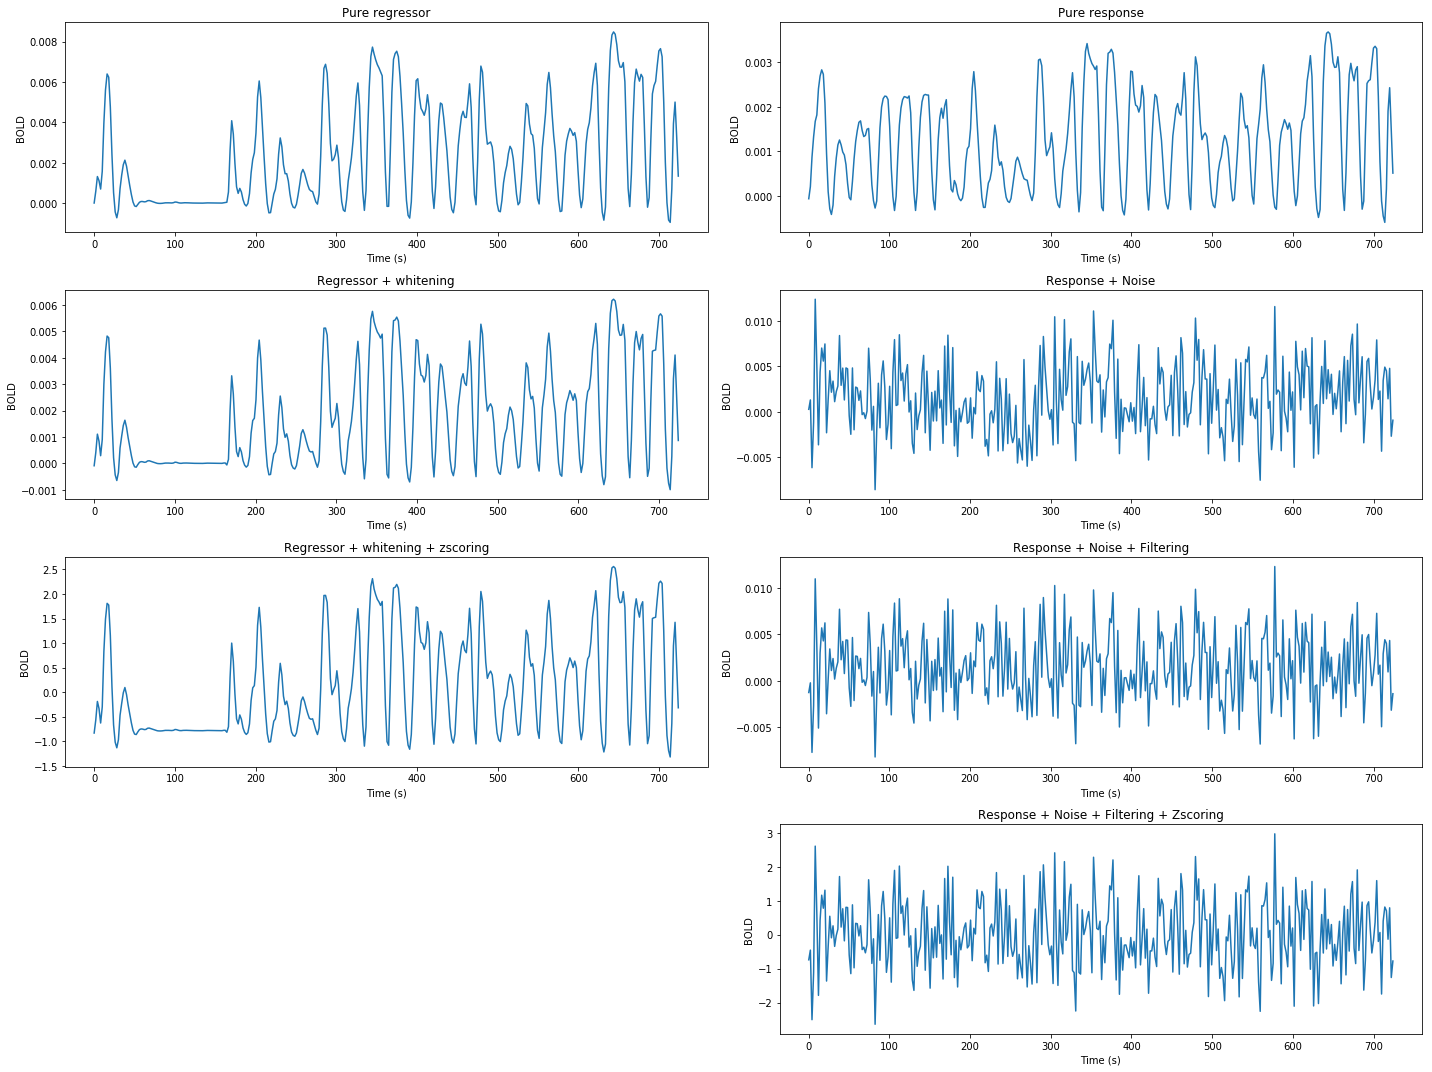

In [11]:
# PICK HERE WHICH REGRESSOR AND RESPONSE TO VISUALIZE
####################################################
k_scheme = 0
k_N = 1
k_fraction = 9
k_subject = 0
k_session = 3
i = 1   # Index of the regressor to visualize
####################################################

y1_plot = copy.deepcopy(y_without_noise[k_scheme][k_N][k_fraction][k_subject][k_session])
y2_plot = copy.deepcopy(y_with_noise[k_scheme][k_N][k_fraction][k_subject][k_session])
y3_plot = copy.deepcopy(y_after_filtering[k_scheme][k_N][k_fraction][k_subject][k_session])
y4_plot = copy.deepcopy(yz[k_scheme][k_N][k_fraction][k_subject][k_session])

x1_plot = copy.deepcopy(X_before_whitening[k_scheme][k_N][k_subject][k_session][:, i])
x2_plot = copy.deepcopy(X_after_whitening[k_scheme][k_N][k_subject][k_session][:, i])
x3_plot = copy.deepcopy(Xz[k_scheme][k_N][k_subject][k_session][:, i])

fig = plt.figure(figsize=(20, 15))

ax_up = fig.add_subplot(421)
between_scans_time = 2.0
ax_up.set_xlabel('Time (s)')
ax_up.set_ylabel('BOLD')
ax_up.set_title('Pure regressor')
ax_up.plot(np.linspace(0, between_scans_time*len(x1_plot), len(x1_plot)), x1_plot)

ax_down = fig.add_subplot(423)
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor + whitening')
ax_down.plot(np.linspace(0, between_scans_time*len(x2_plot), len(x2_plot)), x2_plot)

ax_down = fig.add_subplot(425)
ax_down.set_xlabel('Time (s)')
ax_down.set_ylabel('BOLD')
ax_down.set_title('Regressor + whitening + zscoring')
ax_down.plot(np.linspace(0, between_scans_time*len(x3_plot), len(x3_plot)), x3_plot)

ax1 = fig.add_subplot(422)
ax1.plot(np.linspace(0, between_scans_time*len(y1_plot), len(y1_plot)), y1_plot)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('BOLD')
ax1.set_title('Pure response')

ax2 = fig.add_subplot(424)
ax2.plot(np.linspace(0, between_scans_time*len(y2_plot), len(y2_plot)), y2_plot)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('BOLD')
ax2.set_title('Response + Noise')

ax3 = fig.add_subplot(426)
ax3.plot(np.linspace(0, between_scans_time*len(y3_plot), len(y3_plot)), y3_plot)
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('BOLD')
ax3.set_title('Response + Noise + Filtering')

ax4 = fig.add_subplot(428)
ax4.plot(np.linspace(0, between_scans_time*len(y4_plot), len(y4_plot)), y4_plot)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('BOLD')
ax4.set_title('Response + Noise + Filtering + Zscoring')
fig.tight_layout()
plt.show()


## Regression

### Visualization of an example of training and testing

Here we select arbitrary values of hyperparameters and plot the result for one fit.


Scheme : gaussian_ppc
true_N = 4
fit_N = 4
Subject n°0
Left-out session : 3


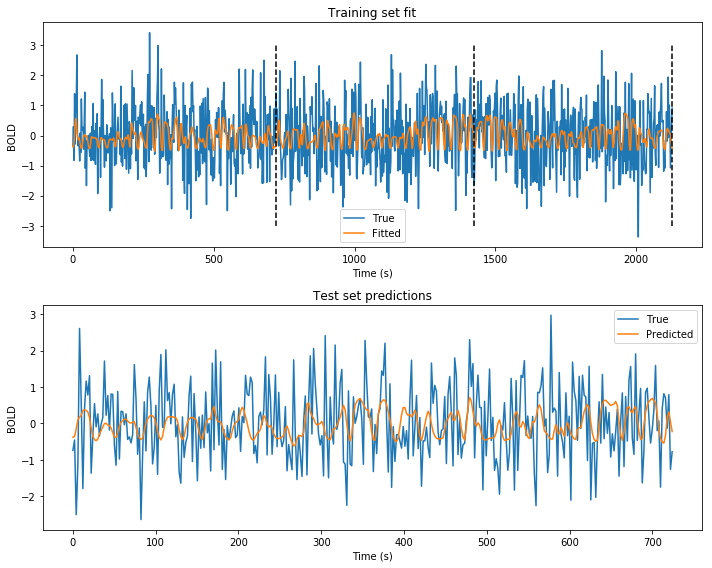

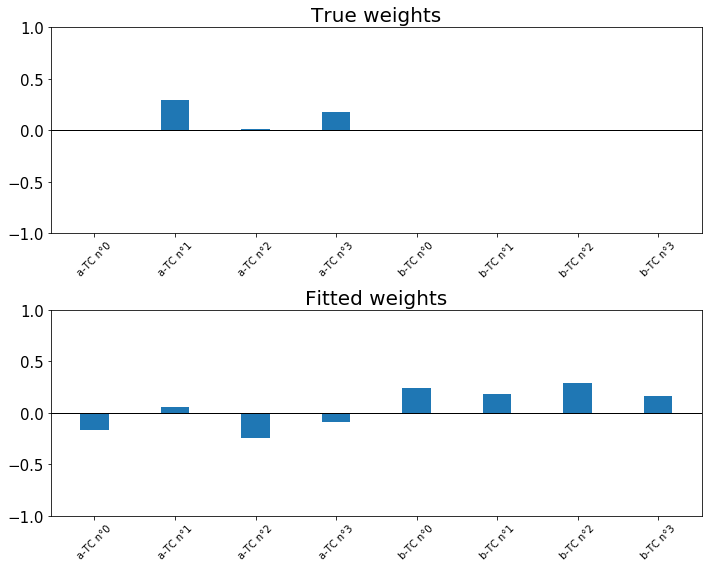

In [13]:
# PICK HERE WHICH MODEL, SET, ETC. TO VISUALIZE
#######################################
k_scheme = 0
k_fraction = 9
k_fit_N = 1
k_true_N = 1
k_subject = 0
k_session = 3    # Left-out session
#######################################

true_N = N_array[k_true_N]
fit_N = N_array[k_fit_N]

print('Scheme : '+scheme_array[k_scheme]+'\n'+'true_N = '+str(true_N)+'\nfit_N = '+str(fit_N)
      +'\n'+'Subject n°'+str(k_subject)+'\nLeft-out session : '+str(k_session))

# Current cross-validation matrice and response
X_cv = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject])
y_cv = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject])

X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
X_test = copy.deepcopy(X_cv[k_session])
y_test = copy.deepcopy(y_cv[k_session])

# Train the model using the training set
regr.fit(X_train, y_train)
y_hat_train = regr.predict(X_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# Train and test results
r2_test = r2_score(y_test, y_pred)
r2_train = r2_score(y_train, y_hat_train)
rho_train = pearsonr(y_train, y_hat_train)[0]
rho_test = pearsonr(y_pred, y_test)[0]


# Plot the signal and the response
# WEIRD IT DOESNT OWRK ANYMORE
fig1 = plt.figure(figsize=(10,8))
ax_y_train = fig1.add_subplot(211)
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_train), len(y_train)), y_train, label='True')
ax_y_train.plot(np.linspace(0, between_scans_time*len(y_hat_train), len(y_hat_train)), y_hat_train, label='Fitted')
ax_y_train.legend()
ax_y_train.set_xlabel('Time (s)')
ax_y_train.set_ylabel('BOLD')
ax_y_train.set_title('Training set fit')
# Separate sessions
#print(str(y_cv[0]))
dash_line = [None for k in range(n_sessions-1)]
dash_position = 0
for k in range(n_sessions-1):
    dash_position += between_scans_time*len(y_cv[k])
    dash_line[k] = ax_y_train.plot(dash_position*np.ones(10), np.linspace(-3, 3, 10), color='black', linestyle='--')

ax_y_test = fig1.add_subplot(212)
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_test), len(y_test)), y_test, label='True')
ax_y_test.plot(np.linspace(0, between_scans_time*len(y_pred), len(y_pred)), y_pred, label='Predicted')
ax_y_test.legend()
ax_y_test.set_xlabel('Time (s)')
ax_y_test.set_ylabel('BOLD')
ax_y_test.set_title('Test set predictions')
fig1.tight_layout()

## Plot the weights

true_weights = weights[k_scheme][k_true_N][k_fraction][k_subject]
fit_weights = regr.coef_

# Plot the true weights
width = 1/np.sqrt((2*true_N))

fig2 = plt.figure(figsize=(10,8))
ax_true_weights = fig2.add_subplot(211)
labels = [None for k in range(2*true_N)]
for k in range(2*true_N):
    if k<true_N:
        labels[k] = 'a-TC n°'+str(k%true_N)
    else:
        labels[k] = 'b-TC n°'+str(k%true_N)
ax_true_weights.bar(labels, true_weights, width=width)
ax_true_weights.tick_params(labelsize=15)
ax_true_weights.set_title('True weights', fontsize=20)
ax_true_weights.set_ylim([-1, 1])
ax_true_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_true_weights.axhline(0, color="black", linewidth=1)

width = 1/np.sqrt((2*fit_N))
ax_fit_weights = fig2.add_subplot(212)
labels = [None for k in range(2*fit_N)]
for k in range(2*fit_N):
    if k<fit_N:
        labels[k] = 'a-TC n°'+str(k%fit_N)
    else:
        labels[k] = 'b-TC n°'+str(k%fit_N)
ax_fit_weights.bar(labels, fit_weights, width=width)
ax_fit_weights.tick_params(labelsize=15)
ax_fit_weights.set_title('Fitted weights', fontsize=20)
ax_fit_weights.set_ylim([-1, 1])
ax_fit_weights.set_xticklabels(labels, rotation=45, fontsize=10)
ax_fit_weights.axhline(0, color="black", linewidth=1)
fig2.tight_layout()
plt.show()


### Cross-validation loops (simulation 1)

In [14]:
# The loops
# The quantity to be computed during the cross validation
r2_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
r2_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_test = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))
rho_train = np.zeros((n_schemes, n_N, n_N, n_fractions, n_subjects, n_sessions))

### BEGINNING OF LOOPS OVER HYPERPARAMETERS
for k_scheme, k_fit_N, k_true_N, k_fraction, k_subject in itertools.product(range(n_schemes), 
                                                                            range(n_N), range(n_N), range(n_fractions), range(n_subjects)):
    # Current cross-validation matrix and response
    X_cv = copy.deepcopy(Xz[k_scheme][k_fit_N][k_subject])
    y_cv = copy.deepcopy(yz[k_scheme][k_true_N][k_fraction][k_subject])
    # LOOP OVER SESSIONS (CV)
    for k_session in range(n_sessions):
        X_train = copy.deepcopy(np.concatenate(X_cv[:k_session]+X_cv[k_session+1:], axis=0))
        y_train = copy.deepcopy(np.concatenate(y_cv[:k_session]+y_cv[k_session+1:], axis=0))
        X_test = copy.deepcopy(X_cv[k_session])
        y_test = copy.deepcopy(y_cv[k_session])

        # Train the model using the training set
        regr.fit(X_train, y_train)
        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        # Updates the big tensor
        y_hat_train = regr.predict(X_train)
        r2_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = r2_score(y_train, y_hat_train)
        r2_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = r2_score(y_test, y_pred)
        rho_train[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = pearsonr(y_train, y_hat_train)[0]
        rho_test[k_scheme, k_fit_N, k_true_N, k_fraction, k_subject, k_session] \
            = pearsonr(y_pred, y_test)[0]
        # with open("output/results/Output.txt", "w") as text_file:
        #     text_file.write('k_fit_scheme={} k_fit_N={} k_true_N={} k_subject={} k_population_fraction={} k_subpopulation_fraction={} k_session={} \nr2={} \n'.format(
        #         k_fit_scheme, k_fit_N, k_true_N, k_subject, k_population_fraction, k_subpopulation_fraction, k_session,
        #         r2_score(y_test, y_pred)))
        # print('Completed : k_fit_scheme={} k_fit_N={} k_true_N={} k_subject={} k_population_fraction={} k_subpopulation_fraction={} k_session={} \nr2={} \nr2_train={}'.format(
        #         k_fit_scheme, k_fit_N, k_true_N, k_subject, k_population_fraction, k_subpopulation_fraction, k_session,
        #         r2_score(y_test, y_pred), r2_train))

# Histogram of r2_train for each fit_N and true_N

r2_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
r2_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_train_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))
rho_test_summary = np.zeros((n_schemes, n_N, n_N, n_fractions*n_subjects*n_sessions))

np.save('output/results/r2_test_snr'+str(snr)+'.npy', r2_test)
np.save('output/results/r2_train_snr'+str(snr)+'.npy', r2_train)
np.save('output/results/rho_test_snr'+str(snr)+'.npy', rho_test)
np.save('output/results/rho_train_snr'+str(snr)+'.npy', rho_train)


In [15]:
# Some reloading (run that if the loops have already been performed and results saved)
r2_test = np.load('output/results/r2_test_snr'+str(snr)+'.npy')
r2_train = np.load('output/results/r2_train_snr'+str(snr)+'.npy')
rho_test = np.load('output/results/rho_test_snr'+str(snr)+'.npy')
rho_train = np.load('output/results/rho_train_snr'+str(snr)+'.npy')

#for k_scheme, k_fit_N, k_true_N in itertools.product(range(n_schemes), range(n_N), range(n_N)):
    r2_train_summary[k_scheme, k_fit_N, k_true_N] = r2_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    r2_test_summary[k_scheme, k_fit_N, k_true_N] = r2_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_train_summary[k_scheme, k_fit_N, k_true_N] = rho_train[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()
    rho_test_summary[k_scheme][k_fit_N][k_true_N] = rho_test[k_scheme, k_fit_N, k_true_N, :, :, :].flatten()


### Visualize results from simulation 1 (one example)

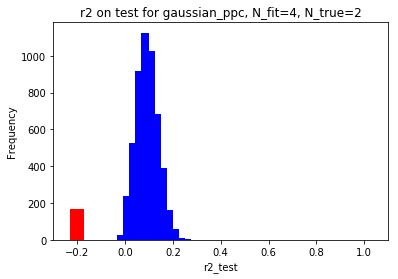

r2 var: 0.00480456759910746
r2 mean: 0.0935563064031803


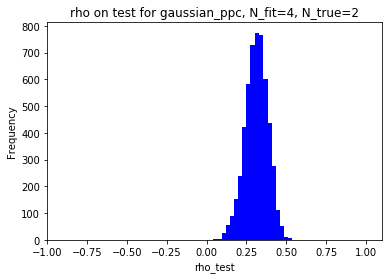

rho var: 0.004892277496994584
rho mean: 0.323921440690211


In [17]:
# Visualize one specific plot

#########################################
k_scheme = 0
k_fit_N = 1
k_true_N = 0
##########################################

scheme = scheme_array[k_scheme]
fit_N = N_array[k_fit_N]
true_N = N_array[k_true_N]

#r2
metric_name = 'r2'
train_or_test = 'test'
exec("metric = %s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, train_or_test))

# We set the negative r2 to the same value
negative_center = -0.2
n_negative_values = 0
if metric_name.find('r2')!=-1:
    for k, metric_value in enumerate(metric):
        if metric_value <0:
            metric[k] = negative_center
            n_negative_values += 1

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
ax.bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
ax.set_title(metric_name+' on '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-0.3, 1.1])
plt.show()

print('r2 var: '+str(np.var(metric)))
print('r2 mean: '+str(np.mean(metric)))

# rho
metric_name = 'rho'
train_or_test = 'test'
exec("metric = %s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, train_or_test))

nbins = 20
width = 0.03
fig = plt.figure()
ax = fig.add_subplot(111) 
ax.hist(metric, bins=nbins, align='left', color='b', width=width)
ax.set_title(metric_name+' on '+train_or_test+' for '+scheme+', N_fit='+str(fit_N)+', N_true='+str(true_N))
ax.set_xlabel('{}_{}'.format(metric_name, train_or_test))
ax.set_ylabel("Frequency")
ax.set_xlim([-1, 1.1])
plt.show()

print('rho var: '+str(np.var(metric)))
print('rho mean: '+str(np.mean(metric)))

In [ ]:
################################
k_scheme = 0
################################

scheme = scheme_array[k_scheme]
#r2
metric_name = 'r2'
train_or_test = 'test'

print(metric_name+' on '+train_or_test+' set, '+scheme)

# Visualize the entire confusion matrix
nbins = 20
width = 0.04

fig, ax = plt.subplots(n_N, n_N, sharex='col', sharey='row', figsize = (15, 15))
for k_fit_N in range(n_N):
    for k_true_N in range(n_N):
        exec("metric = %s_%s_summary[k_scheme, k_fit_N, k_true_N]" % (metric_name, train_or_test))
        fit_N = N_array[k_fit_N]
        true_N = N_array[k_true_N]
        # We set the negative r2 to the same value
        negative_center = -0.2
        n_negative_values = 0
        if metric_name.find('r2')!=-1:
            for k, metric_value in enumerate(metric):
                if metric_value <0:
                    metric[k] = negative_center
                    n_negative_values += 1

        ax[k_fit_N, k_true_N].hist(metric, bins=nbins, align='left', color='b', width=width)
        ax[k_fit_N, k_true_N].bar(negative_center, n_negative_values, color='r', width=2*width, align='center')
        ax[k_fit_N, k_true_N].set_title('N_fit='+str(fit_N)+', N_true='+str(true_N))
        ax[k_fit_N, k_true_N].set_xlabel('{}_{}'.format(metric_name, train_or_test))
        ax[k_fit_N, k_true_N].set_ylabel("Frequency")
        if metric_name.find('r2')!=-1:
            ax[k_fit_N, k_true_N].set_xlim([-0.3, 1.1])
        else:
            ax[k_fit_N, k_true_N].set_xlim([-1, 1])
        ax[k_fit_N, k_true_N].set_ylim([0, n_fractions*n_subjects*n_sessions/2])
fig.tight_layout()
plt.show()

print(len(r2_test_summary[0, 0, 0]))

### Find the optimal number of mixtures to be generated, n_fractions

Plot the mean and variance of these distributions for different number of fractions and different subject

Scheme : gaussian_ppc
true_N = 4
fit_N = 4



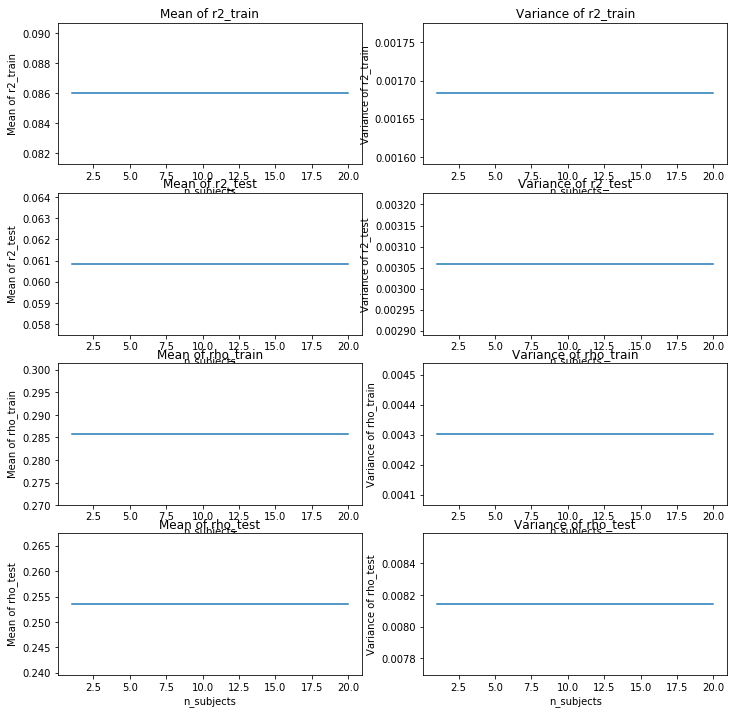

In [21]:
# Find the assymptotical value for n_fractions
n_subjects_array = np.linspace(1, n_subjects, num=n_subjects, endpoint=True).astype(int)

subject_r2_train_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_train_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_r2_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_r2_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_rho_train_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_rho_train_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

subject_rho_test_mean = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))
subject_rho_test_var = np.zeros((n_schemes, n_N, n_N, len(n_subjects_array)))

for k_n_subjects, n_subjects in enumerate(n_subjects_array):
    for k_scheme, k_fit_N, k_true_N in itertools.product(range(n_schemes), range(n_N), range(n_N)):            
        subject_r2_train_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_train_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
                                      
        subject_r2_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(r2_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_r2_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(r2_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
                   
        subject_rho_train_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(rho_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_rho_train_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(rho_train[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

        subject_rho_test_mean[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.mean(rho_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())
        subject_rho_test_var[k_scheme, k_fit_N, k_true_N, k_n_subjects] = \
            np.var(rho_test[k_scheme, k_fit_N, k_true_N, :, :n_subjects, :].flatten())

k_scheme = 0
k_fit_N = 1
k_true_N = 1

true_N = N_array[k_true_N]
fit_N = N_array[k_fit_N]

print('Scheme : '+scheme_array[k_scheme]+'\n'+'true_N = '+str(true_N)+'\nfit_N = '+str(fit_N)
      +'\n')

subject_r2_train_mean_to_plot = subject_r2_train_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_train_var_to_plot = subject_r2_train_var[k_scheme, k_fit_N, k_true_N, :]

subject_r2_test_mean_to_plot = subject_r2_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_r2_test_var_to_plot = subject_r2_test_var[k_scheme, k_fit_N, k_true_N, :]

subject_rho_train_mean_to_plot = subject_rho_train_mean[k_scheme, k_fit_N, k_true_N, :]
subject_rho_train_var_to_plot = subject_rho_train_var[k_scheme, k_fit_N, k_true_N, :]

subject_rho_test_mean_to_plot = subject_rho_test_mean[k_scheme, k_fit_N, k_true_N, :]
subject_rho_test_var_to_plot = subject_rho_test_var[k_scheme, k_fit_N, k_true_N, :]


fig = plt.figure(figsize=(12, 12))
ax_r2_train_mean = fig.add_subplot(421)
ax_r2_train_mean.plot(n_subjects_array, subject_r2_train_mean_to_plot)
ax_r2_train_mean.set_xlabel('n_subjects')
ax_r2_train_mean.set_ylabel('Mean of r2_train')
ax_r2_train_mean.set_title('Mean of r2_train')

ax_r2_train_var = fig.add_subplot(422)
ax_r2_train_var.plot(n_subjects_array, subject_r2_train_var_to_plot)
ax_r2_train_var.set_xlabel('n_subjects')
ax_r2_train_var.set_ylabel('Variance of r2_train')
ax_r2_train_var.set_title('Variance of r2_train')

ax_r2_test_mean = fig.add_subplot(423)
ax_r2_test_mean.plot(n_subjects_array, subject_r2_test_mean_to_plot)
ax_r2_test_mean.set_xlabel('n_subjects')
ax_r2_test_mean.set_ylabel('Mean of r2_test')
ax_r2_test_mean.set_title('Mean of r2_test')

ax_r2_test_var = fig.add_subplot(424)
ax_r2_test_var.plot(n_subjects_array, subject_r2_test_var_to_plot)
ax_r2_test_var.set_xlabel('n_subjects')
ax_r2_test_var.set_ylabel('Variance of r2_test')
ax_r2_test_var.set_title('Variance of r2_test')

ax_rho_train_mean = fig.add_subplot(425)
ax_rho_train_mean.plot(n_subjects_array, subject_rho_train_mean_to_plot)
ax_rho_train_mean.set_xlabel('n_subjects')
ax_rho_train_mean.set_ylabel('Mean of rho_train')
ax_rho_train_mean.set_title('Mean of rho_train')

ax_rho_train_var = fig.add_subplot(426)
ax_rho_train_var.plot(n_subjects_array, subject_rho_train_var_to_plot)
ax_rho_train_var.set_xlabel('n_subjects')
ax_rho_train_var.set_ylabel('Variance of rho_train')
ax_rho_train_var.set_title('Variance of rho_train')

ax_rho_test_mean = fig.add_subplot(427)
ax_rho_test_mean.plot(n_subjects_array, subject_rho_test_mean_to_plot)
ax_rho_test_mean.set_xlabel('n_subjects')
ax_rho_test_mean.set_ylabel('Mean of rho_test')
ax_rho_test_mean.set_title('Mean of rho_test')

ax_rho_test_var = fig.add_subplot(428)
ax_rho_test_var.plot(n_subjects_array, subject_rho_test_var_to_plot)
ax_rho_test_var.set_xlabel('n_subjects')
ax_rho_test_var.set_ylabel('Variance of rho_test')
ax_rho_test_var.set_title('Variance of rho_test')

plt.show()

## Plot confusion matrices for simulation 1

In [ ]:
# Faire l'analyse du nombre de sujets optimal pour la stabilité des résultats...
# Faire la simulation n°2